In [32]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers
from tensorflow.keras.utils import plot_model
from keras.models import load_model


import pandas as pd
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import warnings
import os
import cv2
warnings.filterwarnings("ignore")

## Daily life image sequences

In [2]:
# Specify the path to the root directory containing the folders
image_prefix = "adl-"
image_suffix = "-cam0-d-"
image_ext = ".png"
root_path = "./data/adl_imgs/"
total_seq = 40
target_size = (64, 64)

# Initialize an empty list to store the image arrays for each folder
image_arrays = []

# Iterate through each folder
for i in range(1, total_seq+1):
    if i<10:
        s = '0' + str(i)
    else:
        s = str(i)
    file_regex = image_prefix + s + image_suffix
    image_name_list = []
    for file_name in os.listdir(root_path):
        if file_regex not in file_name:
            continue
        image_name_list.append(file_name)
        
    image_name_list = sorted(image_name_list)

    # Initialize an empty list to store the images for the current folder
    folder_images = []

    # Iterate through each image in the folder
    for image_name in image_name_list:
        image_path = root_path + image_name

        # Read the image using OpenCV (assuming the images are grayscale)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, target_size)

        # Append the image to the list
        folder_images.append(image)
        if len(folder_images) == 10:
            folder_array = np.array(folder_images)
            image_arrays.append(folder_array) 
            folder_images = []

    # Convert the list of images into a NumPy array
    if len(folder_images) == 10:
        folder_array = np.array(folder_images)
        image_arrays.append(folder_array)

## Fall images sequences

In [3]:
# Specify the path to the root directory containing the folders
image_prefix = "fall-"
image_suffix = "-cam0-d-"
image_ext = ".png"
root_path = "./data/fall_imgs/"
total_seq = 30
target_size = (64, 64)

# Iterate through each folder
for i in range(1, total_seq+1):
    if i<10:
        s = '0' + str(i)
    else:
        s = str(i)
    file_regex = image_prefix + s + image_suffix
    image_name_list = []
    for file_name in os.listdir(root_path):
        if file_regex not in file_name:
            continue
        image_name_list.append(file_name)
        
    image_name_list = sorted(image_name_list)

    # Initialize an empty list to store the images for the current folder
    folder_images = []

    # Iterate through each image in the folder
    for image_name in image_name_list:
        image_path = root_path + image_name

        # Read the image using OpenCV (assuming the images are grayscale)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, target_size)

        # Append the image to the list
        folder_images.append(image)
        if len(folder_images) == 10:
            folder_array = np.array(folder_images)
            image_arrays.append(folder_array) 
            folder_images = []

    # Convert the list of images into a NumPy array
    if len(folder_images) == 10:
        folder_array = np.array(folder_images)
        image_arrays.append(folder_array)

In [4]:
dataset = np.array(image_arrays)

In [5]:
# Save the array
np.save('next_frame_prediction_dataset.npy', dataset)

In [7]:
# Load the array
dataset = np.load('next_frame_prediction_dataset.npy')

In [8]:
print("Shape of the final array:", dataset.shape)

Shape of the final array: (1181, 10, 64, 64)


In [9]:
# Swap the axes representing the number of frames and number of data samples.

# not needed
#dataset = np.swapaxes(dataset, 0, 1)

In [10]:
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

In [19]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.07 * dataset.shape[0])]
val_index = indexes[int(0.95 * dataset.shape[0]) :]

In [20]:
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

In [21]:
# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [22]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [23]:
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

In [24]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (82, 9, 64, 64, 1), (82, 9, 64, 64, 1)
Validation Dataset Shapes: (60, 9, 64, 64, 1), (60, 9, 64, 64, 1)


Displaying frames for example 12.


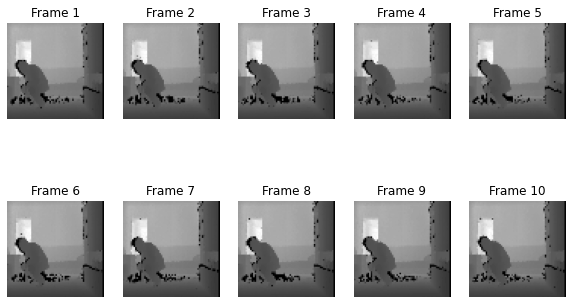

In [25]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 6))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [26]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
)

In [27]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64   416256    
                             )                                   
                                                                 
 batch_normalization (Batch  (None, None, 64, 64, 64   256       
 Normalization)              )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64   295168    
                             )                                   
                                                                 
 batch_normalization_1 (Bat  (None, None, 64, 64, 64   256   

In [28]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

In [30]:
# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
17/17 [==============================] - 177s 10s/step - loss: 0.6257 - val_loss: 0.6928 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 173s 10s/step - loss: 0.6097 - val_loss: 0.6922 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 175s 10s/step - loss: 0.6054 - val_loss: 0.6926 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 178s 11s/step - loss: 0.6043 - val_loss: 0.6923 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 178s 11s/step - loss: 0.6077 - val_loss: 0.6920 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 183s 11s/step - loss: 0.6046 - val_loss: 0.6923 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - 178s 11s/step - loss: 0.6023 - val_loss: 0.6925 - lr: 0.0010
Epoch 8/20
17/17 [==============================] - 193s 11s/step - loss: 0.6034 - val_loss: 0.6915 - lr: 0.0010
Epoch 9/20
17/17 [==============================] - 184s 11s/step - loss: 0.6003 - val_loss: 0.6

In [31]:
# Save the entire model to a file
model.save('trained_next_frame_prediction_model.h5')

In [33]:
model = load_model('trained_next_frame_prediction_model.h5')

1/1 [==============================] - 1s 517ms/step


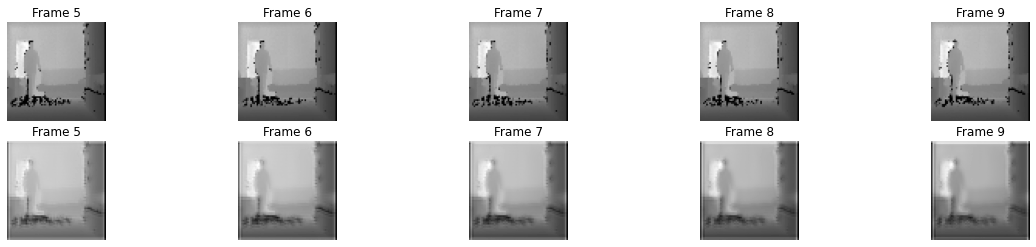

In [36]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last seven frames from the example.
frames = example[:5, ...]
original_frames = example[5:, ...]

# Predict a new set of 7 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 5}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[5:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 5}")
    ax.axis("off")

# Display the figure.
plt.show()